In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
rules = pd.read_csv("test-recommend-output-wocDepSeq-all.csv")
ground_truth = pd.read_csv("possible-ground-truth-2014.csv")
confirmed_rule_set = set(zip(
    ground_truth[ground_truth["dataConfirmed"]]["fromGroupArtifact"], 
    ground_truth[ground_truth["dataConfirmed"]]["toGroupArtifact"]
))
possible_rule_set = set(zip(
    ground_truth[ground_truth["inDepSeq"] > 0]["fromGroupArtifact"], 
    ground_truth[ground_truth["inDepSeq"] > 0]["toGroupArtifact"]
))
rules["isPossible"] = [x in possible_rule_set for x in zip(rules["fromGroupArtifact"], rules["toGroupArtifact"])]
rules["isConfirmed"] = [x in confirmed_rule_set for x in zip(rules["fromGroupArtifact"], rules["toGroupArtifact"])]
rules["popularityRegularization"] = rules["relativeRuleFreq"] * rules["concurrenceAdjustment"]
possible_rules = rules[rules["isPossible"]]
confirmed_rules = rules[rules["isConfirmed"]]
other_rules = rules[~rules["isConfirmed"] & ~rules["isPossible"]]
print("# rules = {}, # confirmed = {}, # possible = {}".format(
    len(rules), len(confirmed_rule_set), len(possible_rule_set)))

# rules = 316328, # confirmed = 289, # possible = 1588


In [3]:
rules

,fromId,toId,fromGroupArtifact,toGroupArtifact,isCorrect,confidence,ruleFreq,relativeRuleFreq,concurrence,concurrenceAdjustment,commitDistance,apiSupport,isPossible,isConfirmed,popularityRegularization
0,48,934,com.h2database:h2,org.postgresql:postgresql,True,8.520790e-02,87,0.896907,755,0.115232,0.601084,0.000000,True,False,0.103352
1,48,176259,com.h2database:h2,org.ikasan:ikasan-h2-standalone-persistence,False,7.985533e-02,10,0.103093,10,1.000000,1.000000,0.000000,False,False,0.103093
2,48,932,com.h2database:h2,javax.servlet:javax.servlet-api,False,6.990698e-02,81,0.835052,722,0.112188,0.568040,0.002079,False,False,0.093683
3,48,1228,com.h2database:h2,org.apache.derby:derby,True,6.469736e-02,46,0.474227,398,0.115578,0.719770,0.000000,True,False,0.054810
4,48,70,com.h2database:h2,mysql:mysql-connector-java,True,5.598635e-02,86,0.886598,1681,0.051160,0.600354,0.000000,False,False,0.045358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316323,47,70016,org.testng:testng,org.jboss.as:jboss-as-mail,False,5.024267e-08,1,0.003817,12,0.083333,0.007673,0.000000,False,False,0.000318
316324,47,66734,org.testng:testng,org.jboss.spec.javax.management.j2ee:jboss-j2e...,False,4.914754e-08,1,0.003817,13,0.076923,0.007742,0.000000,False,False,0.000294
316325,47,83642,org.testng:testng,org.rhq.helpers:rhq-pluginAnnotations,False,4.739578e-08,1,0.003817,17,0.058824,0.008130,0.000000,False,False,0.000225
316326,47,26096,org.testng:testng,org.jboss:jboss-ejb-client,False,4.683534e-08,1,0.003817,15,0.066667,0.007833,0.000000,False,False,0.000254


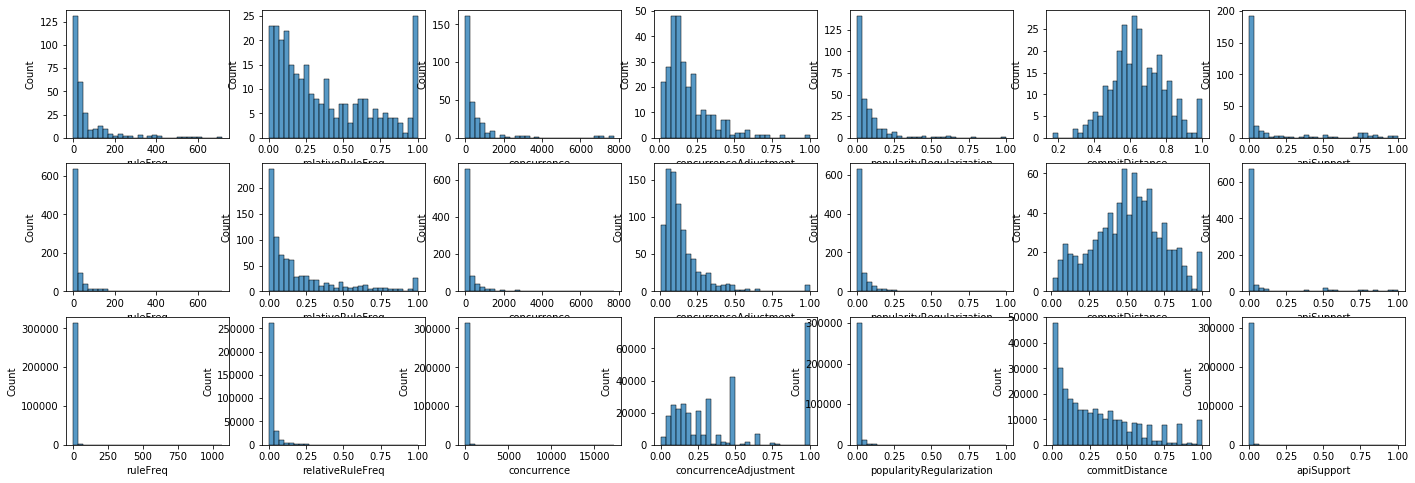

In [4]:
data = [rules[rules["isConfirmed"]], rules[rules["isPossible"]], rules[(~rules["isPossible"]) & (~rules["isConfirmed"])]]
axis = [
    "ruleFreq", "relativeRuleFreq", "concurrence", 
    "concurrenceAdjustment", "popularityRegularization", "commitDistance", "apiSupport"
]
fig, axes = plt.subplots(3, len(axis), figsize=(24, 8))
for i in range(0, 3):
    for j in range(0, len(axis)):
        sns.histplot(data=data[i], x=axis[j], ax=axes[i][j], bins=30)
fig.show()

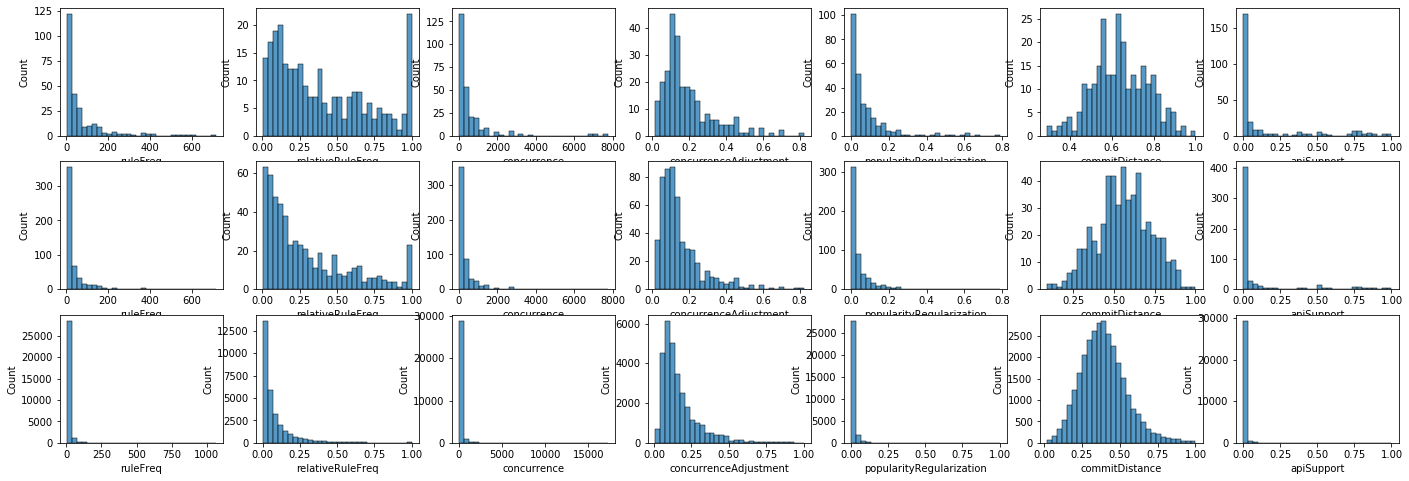

In [5]:
filtered_rules = rules[(rules["ruleFreq"] >= 5) & (rules["concurrence"] >= 10)]
filtered_possible_rules = filtered_rules[filtered_rules["isPossible"]]
filtered_confirmed_rules = filtered_rules[filtered_rules["isConfirmed"]]
data = [
    filtered_rules[filtered_rules["isConfirmed"]], 
    filtered_rules[filtered_rules["isPossible"]], 
    filtered_rules[(~filtered_rules["isPossible"]) & (~filtered_rules["isConfirmed"])]
]
axis = [
    "ruleFreq", "relativeRuleFreq", "concurrence", 
    "concurrenceAdjustment", "popularityRegularization", "commitDistance", "apiSupport"
]
fig, axes = plt.subplots(3, len(axis), figsize=(24, 8))
for i in range(0, 3):
    for j in range(0, len(axis)):
        sns.histplot(data=data[i], x=axis[j], ax=axes[i][j], bins=30)
fig.show()

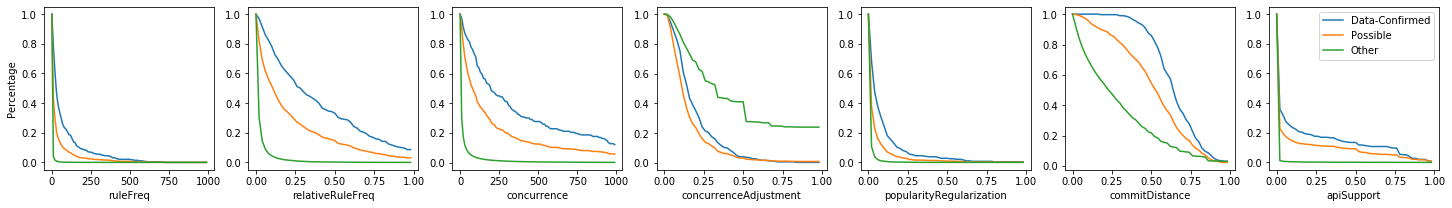

In [7]:
def get_dist(rules, possible_rules, confirmed_rules, metric, min_val, max_val, interval):
    possible_vals = []
    confirmed_vals = []
    other_vals = []
    for i in np.arange(min_val, max_val, interval):
        possible_vals.append(len(possible_rules[possible_rules[metric] >= i]) / len(possible_rules))
        confirmed_vals.append(len(confirmed_rules[confirmed_rules[metric] >= i]) / len(confirmed_rules))
        other_vals.append(len(other_rules[other_rules[metric] >= i]) / len(other_rules))
    return possible_vals, confirmed_vals, other_vals
params = [
    ("ruleFreq", 0, 1000, 10), 
    ("relativeRuleFreq", 0, 1, 0.02), 
    ("concurrence", 0, 1000, 10), 
    ("concurrenceAdjustment", 0, 1, 0.02),
    ("popularityRegularization", 0, 1, 0.02),
    ("commitDistance", 0, 1, 0.02), 
    ("apiSupport", 0, 1, 0.02)
]
fig, axes = plt.subplots(1, len(params), figsize=(25, 3))
for i, param in enumerate(params):
    possible, confirmed, other = get_dist(rules, possible_rules, confirmed_rules, *param)
    x = list(np.arange(param[1], param[2], param[3]))
    axes[i].plot(x, confirmed, label="Data-Confirmed")
    axes[i].plot(x, possible, label="Possible")
    axes[i].plot(x, other, label="Other")
    axes[i].set_xlabel(param[0])
    if i == 0:
        axes[i].set_ylabel("Percentage")
    if i == len(params) - 1:
        axes[i].legend()
fig.show()

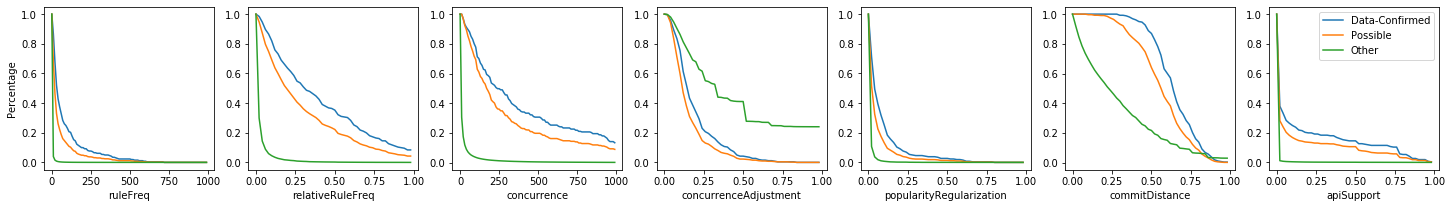

In [8]:
fig, axes = plt.subplots(1, len(params), figsize=(25, 3))
for i, param in enumerate(params):
    possible, confirmed, other = get_dist(filtered_rules, filtered_possible_rules, filtered_confirmed_rules, *param)
    x = list(np.arange(param[1], param[2], param[3]))
    axes[i].plot(x, confirmed, label="Data-Confirmed")
    axes[i].plot(x, possible, label="Possible")
    axes[i].plot(x, other, label="Other")
    axes[i].set_xlabel(param[0])
    if i == 0:
        axes[i].set_ylabel("Percentage")
    if i == len(params) - 1:
        axes[i].legend()
fig.show()

In [9]:
def show_dist2(filter_func):
    print("# possible = {}({:.2%}), # confirmed = {}({:.2%}), # other = {}({:.2%})".format(
            len(filter_func(possible_rules)),
            len(filter_func(possible_rules)) / len(possible_rules),
            len(filter_func(confirmed_rules)),
            len(filter_func(confirmed_rules)) / len(confirmed_rules),
            len(filter_func(other_rules)),
            len(filter_func(other_rules)) / len(other_rules),
    ))
show_dist2(lambda rules: rules[(rules["ruleFreq"] >= 5) & (rules["concurrence"] >= 10)])
show_dist2(lambda rules: rules[(rules["ruleFreq"] >= 2) & (rules["concurrence"] >= 15) & (rules["commitDistance"] >= 0.4)])

# possible = 536(63.43%), # confirmed = 261(90.31%), # other = 30136(9.55%)
# possible = 515(60.95%), # confirmed = 259(89.62%), # other = 23006(7.29%)


In [10]:
def show_dist(metric, min_val, max_val, interval):
    possible_rules = rules[rules["isPossible"]]
    confirmed_rules = rules[rules["isConfirmed"]]
    other_rules = rules[~rules["isConfirmed"] & ~rules["isPossible"]]
    print("Distribution of {}:".format(metric))
    for i in np.arange(min_val, max_val, interval):
        print("{} >= {:.2f}: # possible = {}({:.2%}), # confirmed = {}({:.2%}), # other = {}({:.2%})".format(
            metric, i,
            len(possible_rules[possible_rules[metric] >= i]),
            len(possible_rules[possible_rules[metric] >= i]) / len(possible_rules),
            len(confirmed_rules[confirmed_rules[metric] >= i]),
            len(confirmed_rules[confirmed_rules[metric] >= i]) / len(confirmed_rules),
            len(other_rules[other_rules[metric] >= i]),
            len(other_rules[other_rules[metric] >= i]) / len(other_rules),
        ))
    print("")
params = [
    ("ruleFreq", 0, 30, 1), 
    ("relativeRuleFreq", 0, 1, 0.02), 
    ("concurrence", 0, 30, 1), 
    ("concurrenceAdjustment", 0, 1, 0.02),
    ("commitDistance", 0, 1, 0.02), 
    ("apiSupport", 0, 1, 0.02)
]
for param in params:
    show_dist(*param)

Distribution of ruleFreq:
ruleFreq >= 0.00: # possible = 845(100.00%), # confirmed = 289(100.00%), # other = 315483(100.00%)
ruleFreq >= 1.00: # possible = 845(100.00%), # confirmed = 289(100.00%), # other = 315483(100.00%)
ruleFreq >= 2.00: # possible = 732(86.63%), # confirmed = 285(98.62%), # other = 122383(38.79%)
ruleFreq >= 3.00: # possible = 647(76.57%), # confirmed = 280(96.89%), # other = 63730(20.20%)
ruleFreq >= 4.00: # possible = 580(68.64%), # confirmed = 269(93.08%), # other = 42493(13.47%)
ruleFreq >= 5.00: # possible = 536(63.43%), # confirmed = 261(90.31%), # other = 31015(9.83%)
ruleFreq >= 6.00: # possible = 486(57.51%), # confirmed = 253(87.54%), # other = 24291(7.70%)
ruleFreq >= 7.00: # possible = 448(53.02%), # confirmed = 242(83.74%), # other = 19852(6.29%)
ruleFreq >= 8.00: # possible = 416(49.23%), # confirmed = 234(80.97%), # other = 16699(5.29%)
ruleFreq >= 9.00: # possible = 392(46.39%), # confirmed = 231(79.93%), # other = 14276(4.53%)
ruleFreq >= 10.00: #